<a href="https://colab.research.google.com/github/chriscandido/GEE/blob/main/Land_cover_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Package**

In [1]:
import ee
import math
import folium
import subprocess
import numpy as np
import pandas as pd

from numpy import sort
from pprint import pprint
from folium import plugins
from IPython.display import Image
from IPython.display import display

try:
    import geemap
except ImportError:
    print('Installing geemap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

try:
    import ipygee
except ImportError:
    print('Installing ipygee ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'ipygee'])

import pprint
import geemap 
import geemap.eefolium as geemap
from ipygee import *

# Configure the pretty printing output & initialize earthengine.
pp = pprint.PrettyPrinter(depth=4)

Installing geemap ...
Installing ipygee ...


In [3]:
# Google Earth Engine Authentication
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=E4mRFB41dAgefDNGNXnGDy5qBiH8xiWIHDFsc3hcGXA&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiyeGJ0EE5zr0xVaHDbHlyTzAayiGnHuK06waOCll3go9Q0Y4ZJRQA

Successfully saved authorization token.


In [4]:
ee.Initialize()

In [5]:
AOI = ee.Geometry.Polygon([[[120, 15.30],
                            [120, 14],
                            [121.35, 14],
                            [121.35, 15.30]]])
Point_1 = ee.FeatureCollection(
    [ee.Feature(
        ee.Geometry.Point([120.675, 14.65]),
        {
              "system:index": "0"
            })]);
watershed = ee.FeatureCollection('users/cgcandido/ManilaBayWatershed').geometry() 
boundary = ee.FeatureCollection('users/cgcandido/ManilaBayWatershed_boundary').geometry() 

**Basemap**

In [6]:
def add_ee_layer(self, ee_object, vis_params, name): 
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [7]:
basemaps = {
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    )}

**Global Variables**

In [8]:
# Global Variables

# Date
startDate = '2015-01-01'
endDate = '2016-12-31' 

# Landsat 8 Bands
opticalBandL8 = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
thermalBandL8 = ['ST_B10']
bandL8 = opticalBandL8 + thermalBandL8

# Landsat 5 Bands
opticalBandL5 = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
thermalBandL5 = ['B6']
bandL5 = opticalBandL5 + thermalBandL5

# Harmonic Model Variables
dependent = 'EVI'
harmonics = 2
harmonicFrequencies = list(range(1, harmonics+1))

def getNames (base, lst_freq) :
    name_lst = []
    for i in lst_freq:
        name_lst.append(ee.String(base + str(i)))
    return name_lst

cosNames = getNames('cos_', harmonicFrequencies);
sinNames = getNames('sin_', harmonicFrequencies);
independents = ee.List(['constant','t']).cat(cosNames).cat(sinNames);

## **Satellite Image Pre-processing**

*   *Satellite Imagery Access*
*   *Cloud and Cloud-shadow Masking*
*   *Harmonic Regression Modelling*

### **Cloud and Cloud-shadow Masking Landsat Satellite Image**

**Landsat 8**

In [9]:
#Function to cloud mask from the pixel_qa band of Landsat 8 data
def mask(image):
    #Bits 3 and 4 are cloud and cloud shaadow respectively
    cloudBitMask = 1 << 3
    cloudShadowBitMask = 1 << 4
    
    #Get QA Pixel Band
    qa = image.select('QA_PIXEL')
    
    #Flag set to zero which indicated clear conditions
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(qa.bitwiseAnd(cloudBitMask).eq(0))
 
    #Return the masked image, scaled reflectance, without QA bands
    opticalBands = image.updateMask(mask).multiply(0.0000275).select(opticalBandL8).copyProperties(image, ["system:time_start"])
    thermalBands = image.updateMask(mask).multiply(0.00341802).add(149.0).select(thermalBandL8).copyProperties(image, ["system:time_start"])
    
    return image.addBands(opticalBands).addBands(thermalBands)


**Landsat 5**

In [10]:
def maskL5(image):
    qa = image.select('pixel_qa');
    #If the cloud bit (5) is set and the cloud confidence (7) is high
    #or the cloud shadow bit is set (3), then it's a bad pixel.
    cloud = qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    
    #Remove edge pixels that don't occur in all bands
    mask2 = image.mask().reduce(ee.Reducer.min());
    
    return image.updateMask(cloud.Not()).updateMask(mask2).divide(10000).select(opticalBandL5).copyProperties(image, ["system:time_start"])

### **Harmonic Regression**

In [11]:
def addConstant(image):
    return image.addBands(ee.Image(1));

def addTime(image):
    date = ee.Date(image.get('system:time_start'));
    years = date.difference(ee.Date('1970-01-01'), 'year');
    timeRadians = ee.Image(years.multiply(2*math.pi));
    return image.addBands(timeRadians.rename('t').float());

def addHarmonics(image):
    frequencies = ee.Image.constant(harmonicFrequencies)
    time = ee.Image(image).select('t')
    cosines = time.multiply(frequencies).cos().rename(cosNames)
    sines = time.multiply(frequencies).sin().rename(sinNames)
    return image.addBands(cosines).addBands(sines);

In [12]:
#Landsat 8 Enhanced Vegetation Index (EVI)
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_8DAY_EVI') #USGS Landsat 8 Level 2, Collection 2, Tier 1
eviLandsat8 = collection.filterDate(startDate, endDate).filterBounds(boundary).select('EVI')

#Harmonic
harmonicLandsat = eviLandsat8.map(addConstant).map(addTime).map(addHarmonics)

In [13]:
#Landsat 5 Enhanced Vegetation Index (EVI)
collection = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') #USGS Landsat 5 Level 2, Collection 2, Tier 1
eviLandsat5 = collection.filterDate('2010-01-01', '2011-12-31').filterBounds(boundary).map(maskL5).map(addTasseledCap)

#Harmonic
harmonicLandsat5 = eviLandsat5.map(addConstant).map(addTime).map(addHarmonics)

NameError: ignored

In [14]:
# Compute a linear trend.  This will have two bands: 'residuals' and 
# a 2x1 band called coefficients (columns are for dependent variables).
harmonicTrend = harmonicLandsat.select(independents.add(dependent))\
                                .reduce(ee.Reducer.linearRegression(independents.length(),1))

# Flatten the coefficients into a 2-band image|
harmonicTrendCoefficients = harmonicTrend.select('coefficients').arrayProject([0]).arrayFlatten([independents])

#Compute fitted values 
fittedHarmonic = harmonicLandsat.map(lambda image : image\
                                    .addBands(image.select(independents)\
                                    .multiply(harmonicTrendCoefficients)\
                                    .reduce('sum')\
                                    .rename('fitted')));

In [13]:
#Annual Crop
annualCrop = ee.FeatureCollection('users/cgcandido/validation').filter(ee.Filter.eq('lc3', 'annualCrop')) 
MD_ndvi = chart.Image.series(**{'imageCollection': fittedHarmonic,  'region': annualCrop,
'reducer': ee.Reducer.mean(),
'bands' : ['fitted', 'EVI'],
'scale': 500,
'xProperty': 'system:time_start'})
MD_ndvi.renderWidget(width='100%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

## **Dataset Preparation**

<b>1. Harmonic Modelling Features</b>
<br>
<blockquote>
    1.1. Mean, Median, Max, Min, and Std Dev Enhanced Vegetation Index (EVI)<br>
    1.2. Phase<br>
    1.3. Amplitude
</blockquote>
<br>
<b>2. Seasonal Composite</b>
<blockquote>
    1.1. Spectral Bands<br>
    1.2. Normalized Difference Water Index (NDWI)<br>
    1.3. Normalized Difference Built-up Index (NDBI)<br>
    1.4. Normalized Difference Vegetation Index (NDVI)<br>
</blockquote>
<br>
<b>2. Othe Features</b>
<blockquote>
    1.1. Nightime Lights<br>
    1.2. Topographic Features (DEM, Slope, Topo Diversity)<br>
</blockquote>


























































































































































































































































### **Harmonic Modelling Features**

In [15]:
#Compute phase, amplitude, and mean EVI
phase = harmonicTrendCoefficients.select('sin_1')\
                                    .atan2(harmonicTrendCoefficients.select('cos_1'))\
                                    .unitScale(-math.pi, math.pi)\
                                    .rename('phase')

amplitude = harmonicTrendCoefficients.select('sin_1')\
                                    .hypot(harmonicTrendCoefficients.select('cos_1'))\
                                    .multiply(5)\
                                    .rename('amplitude')

medEVI = fittedHarmonic.select(['EVI']).median().rename('medianEVI')
aveEVI = fittedHarmonic.select(['EVI']).mean().rename('averageEVI')
maxEVI = fittedHarmonic.select(['EVI']).max().rename('maximumEVI')
minEVI = fittedHarmonic.select(['EVI']).min().rename('minimumEVI')
stdEVI = fittedHarmonic.select(['EVI']).reduce(ee.Reducer.stdDev()).rename('stddevEVI')

harmonicsRgb = ee.Image.cat([phase, amplitude, stdEVI]).hsvToRgb().clip(watershed)
harmonicsRgb2 = ee.Image.cat([phase, amplitude, medEVI]).hsvToRgb().clip(watershed)

### **Seasonal Composite**

In [16]:
def addNDVI(image):
    return image.addBands(image.normalizedDifference(['SR_B5_1', 'SR_B4_1']).rename('NDVI'));

def addNDWI(image):
    return image.addBands(image.normalizedDifference(['SR_B5_1', 'SR_B6_1']).rename('NDWI'));

def addNDBI(image):
    return image.addBands(image.normalizedDifference(['SR_B6_1', 'SR_B5_1']).rename('NDBI'));

def addGrayScale(image):
    
    grayscale = image.expression(
      '(0.3 * R) + (0.59 * G) + (0.11 * B)', {
      'R': image.select(['SR_B4_1']),
      'G': image.select(['SR_B3_1']),
      'B': image.select(['SR_B2_1'])}).rename('grayscale')
    
    return image.addBands(grayscale)

def addEBBI(image):

    ebbi = image.expression(
        '(MIR - NIR) / (10 * sqrt(MIR + TIR))', {
            'NIR': image.select(['SR_B5_1']),
            'MIR': image.select(['SR_B6_1']),
            'TIR': image.select(['ST_B10_1'])
        }
    ).rename('EBBI')

    return image.addBands(ebbi)

def addSAVI(image):

    savi = image.expression(
        '(NIR - R) * (1 + L) / (NIR + R + L)', {
            'NIR': image.select(['SR_B5_1']),
            'R'  : image.select(['SR_B4_1']),
            'L': 0.5
        }
    ).rename('SAVI')

    return image.addBands(savi)

def addNDISI(image):

    ndisi = image.expression(
        '(TIR - ((WI + NIR + MIR) / 3)) / (TIR + ((WI + NIR + MIR) / 3))', {
            'TIR': image.select(['ST_B10_1']),
            'WI' : image.select(['NDWI']),
            'NIR': image.select(['SR_B5_1']),
            'MIR': image.select(['SR_B6_1'])
        }
    ).rename('NDISI')

    return image.addBands(ndisi)
    

In [17]:
#Use Landsat 8 surface reflectance data
drySet01 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2015-01-01', '2015-05-31').map(mask)
drySet02 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2015-11-01', '2016-05-31').map(mask)
drySet03 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2016-11-01', '2016-12-31').map(mask)
dryImage = drySet01.merge(drySet02).merge(drySet03)

wetSet01 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2015-06-01', '2015-10-31').map(mask)
wetSet02 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2016-06-01', '2016-12-31').map(mask)
wetImage = wetSet01.merge(wetSet02)

dryMean = dryImage.mean().clip(watershed).select(['SR_B1_1','SR_B2_1','SR_B3_1','SR_B4_1','SR_B5_1','SR_B6_1','SR_B7_1','ST_B10'])\
                                    .rename(['DRY_SR_B1','DRY_SR_B2','DRY_SR_B3','DRY_SR_B4','DRY_SR_B5','DRY_SR_B6','DRY_SR_B7','DRY_ST_B10'])
wetMean = wetImage.mean().clip(watershed).select(['SR_B1_1','SR_B2_1','SR_B3_1','SR_B4_1','SR_B5_1','SR_B6_1','SR_B7_1','ST_B10'])\
                                    .rename(['WET_SR_B1','WET_SR_B2','WET_SR_B3','WET_SR_B4','WET_SR_B5','WET_SR_B6','WET_SR_B7','WET_ST_B10'])

In [18]:
# Calculate Band Indices
# Dry and Wet Season NDVI
dryNDVI = dryImage.map(addNDVI).select(['NDVI']).mean().clip(watershed).rename('dryNDVI')
wetNDVI = wetImage.map(addNDVI).select(['NDVI']).mean().clip(watershed).rename('wetNDVI')

# Dry and Wet Season NDWI
dryNDWI = dryImage.map(addNDWI).select(['NDWI']).mean().clip(watershed).rename('dryNDWI')
wetNDWI = wetImage.map(addNDWI).select(['NDWI']).mean().clip(watershed).rename('wetNDWI')

# Dry and Wet Season NDBI
dryNDBI = dryImage.map(addNDBI).select(['NDBI']).mean().clip(watershed).rename('dryNDBI')
wetNDBI = wetImage.map(addNDBI).select(['NDBI']).mean().clip(watershed).rename('wetNDBI')

# Dry and Wet Season SAVI
drySAVI = dryImage.map(addSAVI).select(['SAVI']).mean().clip(watershed).rename('drySAVI')
wetSAVI = wetImage.map(addSAVI).select(['SAVI']).mean().clip(watershed).rename('wetSAVI')

# Dry and Wet Season EBBI
dryEBBI = dryImage.map(addEBBI).select(['EBBI']).mean().clip(watershed).rename('dryEBBI')
wetEBBI = wetImage.map(addEBBI).select(['EBBI']).mean().clip(watershed).rename('wetEBBI')

# Dry and Wet Season NDISI
tempDryNDWI = dryImage.map(addNDWI)
tempWetNDWI = wetImage.map(addNDWI)

dryNDISI = tempDryNDWI.map(addNDISI).select(['NDISI']).mean().clip(watershed).rename('dryNDISI')
wetNDISI = tempWetNDWI.map(addNDISI).select(['NDISI']).mean().clip(watershed).rename('wetNDISI')

In [19]:
# Calculate Texture
kernel = ee.Kernel.square(4, 'pixels')  # filter mean of 5*5

# Compute mean as texture of the landsat 8 collection
dryMedTexture = dryMean.reduceNeighborhood(
    ee.Reducer.median(),
    kernel
)

wetMedTexture = wetMean.reduceNeighborhood(
    ee.Reducer.median(),
    kernel
)

# Compute mean as texture of the landsat 8 collection
dryStdDevTexture = dryMean.reduceNeighborhood(
    ee.Reducer.stdDev(),
    kernel
)

wetStdDevTexture = wetMean.reduceNeighborhood(
    ee.Reducer.stdDev(),
    kernel
)

In [20]:
drystddev_min_max = dryStdDevTexture.reduceRegion(ee.Reducer.minMax(), watershed, 500).getInfo()
pp.pprint(drystddev_min_max)

{'DRY_SR_B1_stdDev_max': 0.07847905390417927,
 'DRY_SR_B1_stdDev_min': 0.0016211216872829475,
 'DRY_SR_B2_stdDev_max': 0.08052670745644688,
 'DRY_SR_B2_stdDev_min': 0.0019618298671848266,
 'DRY_SR_B3_stdDev_max': 0.07862673622226993,
 'DRY_SR_B3_stdDev_min': 0.0019023101193985433,
 'DRY_SR_B4_stdDev_max': 0.08170275658264599,
 'DRY_SR_B4_stdDev_min': 0.0021209523196453017,
 'DRY_SR_B5_stdDev_max': 0.15805828623768495,
 'DRY_SR_B5_stdDev_min': 0.002403213553932231,
 'DRY_SR_B6_stdDev_max': 0.09819857468645235,
 'DRY_SR_B6_stdDev_min': 0.0011615969671127876,
 'DRY_SR_B7_stdDev_max': 0.07611402637499473,
 'DRY_SR_B7_stdDev_min': 0.0009499085980357602,
 'DRY_ST_B10_stdDev_max': 2090.6517428061816,
 'DRY_ST_B10_stdDev_min': 81.53432405940259}


In [19]:
# Max Value Dry
dryndvi_min_max = dryNDVI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
dryndwi_min_max = dryNDWI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
dryndbi_min_max = dryNDBI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
drysavi_min_max = drySAVI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
dryebbi_min_max = dryEBBI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
dryndisi_min_max = dryNDISI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()

# Wet Value Dry
wetndvi_min_max = wetNDVI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
wetndwi_min_max = wetNDWI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
wetndbi_min_max = wetNDBI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
wetsavi_min_max = wetSAVI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
wetebbi_min_max = wetEBBI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
wetndisi_min_max = wetNDISI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()

### **Ancillary Data**

In [21]:
#Elevation model
alos = ee.Image('JAXA/ALOS/AW3D30/V2_2')
alosTopoDiversity = ee.Image('CSP/ERGo/1_0/Global/ALOS_topoDiversity');

elev = alos.select('AVE_DSM').clip(watershed).rename('Elevation');
slope = ee.Terrain.slope(alos.select('AVE_DSM').clip(watershed)).rename('Slope');
topoDiversity = alosTopoDiversity.select('constant').clip(watershed).rename('Topo_Diversity');

#Nighttime Lights 
viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')
nighttimeLights = viirs.filterDate(startDate, endDate).median().clip(watershed).select('avg_rad')

### **Dataset Visualization**

In [21]:
#Visualization parameters
vis_params = {'bands': ['DRY_SR_B4', 'DRY_SR_B3', 'DRY_SR_B2'], 'min': 0.1, 'max': 0.6, 'gamma':[0.90, 0.95, 1.0]}

cov_params = {'bands': ['DRY_SR_B6_variance', 'DRY_SR_B5_variance', 'DRY_SR_B4_variance'], 'min': 0.0, 'max': 6,}

ndvi_params = {'min': dryndvi_min_max['dryNDVI_min'], 'max': dryndvi_min_max['dryNDVI_max'], 'palette': ['#8bc4f9', '#c9995c', '#c7d270', '#8add60', '#097210']}

ndbi_params = {'min': dryndbi_min_max['dryNDBI_min'], 'max': dryndbi_min_max['dryNDBI_max'], 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']}

ndisi_params = {'min': dryndisi_min_max['dryNDISI_min'], 'max': dryndisi_min_max['dryNDISI_max'], 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']}

ndwi_params = {'min': dryndwi_min_max['dryNDWI_min'], 'max': dryndwi_min_max['dryNDWI_max'], 'palette': ['0000FF', '00FFFF']}

savi_params = {'min': drysavi_min_max['drySAVI_min'], 'max': drysavi_min_max['drySAVI_max'], 'palette': ['#8bc4f9', '#c9995c', '#c7d270', '#8add60', '#097210']}

elev_params = {'min': 0, 'max': 1000, 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff'] }

slope_params = {'min': 0, 'max': 90, 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff'] }

topodiv_params = { 'min': 0.0, 'max': 1.0, 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']}

In [ ]:
thumbnail2 = dryStdDevTexture.getThumbURL({
  'min': 0,
  'max': 0.002,
  'bands': ['DRY_SR_B4_variance', 'DRY_SR_B3_variance', 'DRY_SR_B2_variance'],
  'dimensions': 500,
  'region': watershed,
});
print('Rectangle region and palette:', thumbnail2);

Rectangle region and palette: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7586f755e5cb1cb5fd0bf59c40dd1ab7-e075d11cd45e75fd2f95b594ffcf6bed:getPixels


In [23]:
map = geemap.Map()

map.centerObject(Point_1, 8)
map.addLayer(dryMean, vis_params, 'Landsat 8 Satellite Image')
map.addLayer(harmonicsRgb2, {'bands':['red','green','blue'], 'max': 0.7}, 'Phenological Features')
map.addLayer(dryNDVI, ndvi_params, 'Dry Season NDVI')
map.addLayer(dryNDWI, ndwi_params, 'Dry Season NDWI')
map.addLayer(dryNDBI, ndbi_params, 'Dry Season NDBI')
map.addLayer(drySAVI, savi_params, 'Dry Season SAVI')
map.addLayer(dryNDISI, ndisi_params, 'Dry Season NDISI')
map.addLayer(nighttimeLights, {}, 'Night Time Lights')
map.addLayer(elev, elev_params, 'Elevation')
map.addLayer(topoDiversity, topodiv_params, 'Topographic Diversity')
map

## **Classification**

In [22]:
#Image Composite
composite = ee.Image.cat([dryMean,wetMean,\
                          dryNDVI,wetNDVI,dryNDWI,wetNDWI,dryNDBI,wetNDBI,drySAVI,wetSAVI,dryEBBI,wetEBBI,dryNDISI,wetNDISI,\
                          medEVI,aveEVI,maxEVI,minEVI,stdEVI,phase,amplitude,\
                          dryMedTexture,wetMedTexture,dryStdDevTexture,wetStdDevTexture,\
                          elev,slope,topoDiversity,nighttimeLights])

#Band names
bands = ['DRY_SR_B1','DRY_SR_B2','DRY_SR_B3','DRY_SR_B4','DRY_SR_B5','DRY_SR_B6','DRY_SR_B7','DRY_ST_B10',\
        'WET_SR_B1','WET_SR_B2','WET_SR_B3','WET_SR_B4','WET_SR_B5','WET_SR_B6','WET_SR_B7','WET_ST_B10',\
        'dryNDVI','wetNDVI','dryNDWI', 'wetNDWI','dryNDBI','wetNDBI','drySAVI','wetSAVI','dryEBBI','wetEBBI','dryNDISI','wetNDISI',\
        'medianEVI','averageEVI','maximumEVI','minimumEVI','stddevEVI','phase','amplitude',\
        'DRY_SR_B1_median','DRY_SR_B2_median','DRY_SR_B3_median','DRY_SR_B4_median','DRY_SR_B5_median','DRY_SR_B6_median','DRY_SR_B7_median',\
        'WET_SR_B1_median','WET_SR_B2_median','WET_SR_B3_median','WET_SR_B4_median','WET_SR_B5_median','WET_SR_B6_median','WET_SR_B7_median',\
        'DRY_SR_B1_stdDev','DRY_SR_B2_stdDev','DRY_SR_B3_stdDev','DRY_SR_B4_stdDev','DRY_SR_B5_stdDev','DRY_SR_B6_stdDev','DRY_SR_B7_stdDev',\
        'WET_SR_B1_stdDev','WET_SR_B2_stdDev','WET_SR_B3_stdDev','WET_SR_B4_stdDev','WET_SR_B5_stdDev','WET_SR_B6_stdDev','WET_SR_B7_stdDev',\
        'Elevation','Slope','Topo_Diversity','avg_rad']

In [26]:
pp.pprint(composite.getInfo())

{'bands': [{'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'max': 1.8022125,
                          'min': 0,
                          'precision': 'double',
                          'type': 'PixelType'},
            'dimensions': [2, 4],
            'id': 'DRY_SR_B1',
            'origin': [120, 13]},
           {'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'max': 1.8022125,
                          'min': 0,
                          'precision': 'double',
                          'type': 'PixelType'},
            'dimensions': [2, 4],
            'id': 'DRY_SR_B2',
            'origin': [120, 13]},
           {'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'max': 1.8022125,
                          'min': 0,
                          'precision': 'double',
                          'type': 'PixelType'},
            'dimensions': [2

In [27]:
def ee_to_pandas(ee_object):
    """Converts an ee.FeatureCollection to pandas dataframe.

    Args:
        ee_object (ee.FeatureCollection): ee.FeatureCollection.

    Raises:
        TypeError: ee_object must be an ee.FeatureCollection

    Returns:
        pd.DataFrame: pandas DataFrame
    """
    import pandas as pd

    if not isinstance(ee_object, ee.FeatureCollection):
        raise TypeError("ee_object must be an ee.FeatureCollection")

    try:
        data = ee_object.map(lambda f: ee.Feature(None, f.toDictionary()))
        data = [x["properties"] for x in data.getInfo()["features"]]
        df = pd.DataFrame(data)
        return df
    except Exception as e:
        raise Exception(e)

### **Training Dataset Preparation**

In [28]:
features = ee.FeatureCollection('users/cgcandido/validation')

trainingData = ee_to_pandas(features)
trainingData #Land cover types

id                lc2            lc3
0    1              water    aquaculture
1   11              water          water
2    6            wetland       mangrove
3    2           bareLand     barrenLand
4    4         naturalVeg         forest
5    5         naturalVeg      grassLand
6    9         naturalVeg      shrubLand
7    0     cultivatedLand     annualCrop
8    8     cultivatedLand  permanentCrop
9    7     cultivatedLand      paddyRice
10   3  artificialSurface     denseUrban
11  10  artificialSurface    sparseUrban

In [29]:
training = composite.select(bands).sampleRegions(**{\
        'collection':features,\
        'properties':['id'],\
        'scale':90,\
        'geometries': True,\
        'tileScale':16 })

#Export Training dataset
task = ee.batch.Export.table.toDrive(**{'collection':training,\
  'folder':'Colab Notebooks',\
  'description':'Training',\
  'fileFormat':'CSV'\
});

task.start()

### **Feature and Model Selection**

In [28]:
!pip uninstall scikit-learn -y
!pip install -U pycaret scikit-learn
!pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"
!pip install xgboost
!pip install catboost

# Sklearn
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score

# Miscellaneous
import warnings
import subprocess
import seaborn as sns
import lightgbm as lgbm
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

import pycaret
from pycaret.utils import enable_colab 
from pycaret.classification import *
from pycaret.utils import check_metric
enable_colab()

# BorutaShap
!pip3 install BorutaShap
from BorutaShap import BorutaShap

# Shap
!pip3 install shap
import shap

# eli5
!pip3 install eli5
import eli5
from eli5.sklearn import PermutationImportance

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 266 kB 7.0 MB/s 
     |████████████████████████████████| 23.1 MB 12 kB/s 
     |████████████████████████████████| 2.0 MB 52.8 MB/s 
     |████████████████████████████████| 6.8 MB 69.4 MB/s 
     |████████████████████████████████| 271 kB 64.9 MB/s 
     |████████████████████████████████| 14.6 MB 68.9 MB/s 
     |████████████████████████████████| 56 kB 6.1 MB/s 
     |████████████████████████████████| 1.7 MB 91.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.3 MB 53.2 MB/s 
     |████████████████████████████████| 111 kB 103.3 MB/s 
     |████████████████████████████████| 80 kB 10.9 MB/s 
     |████████████████████████████████| 261 kB 6

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 76.4 MB 43 kB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Colab mode enabled.
     |████████████████████████████████| 356 kB 8.0 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491646 sha256=2adcfd79f87250aa149ad15ab703f7892a64e2e6b2b47b178dd691f7be692b55
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
     |████████████████████████████████| 106 kB 9.2 MB/s 


In [30]:
# Load Data
path = '/content/drive/MyDrive/Colab Notebooks/Training.csv'
data = pd.read_csv(path)

In [31]:
data.describe()

DRY_SR_B1  DRY_SR_B1_median  DRY_SR_B1_stdDev     DRY_SR_B2  \
count  77681.000000      77681.000000      77681.000000  77681.000000   
mean       0.222383          0.221489          0.006826      0.230450   
std        0.026046          0.022069          0.006806      0.026314   
min        0.129516          0.151196          0.000811      0.157135   
25%        0.210508          0.211118          0.003520      0.214975   
50%        0.218565          0.218514          0.004820      0.223509   
75%        0.232144          0.231890          0.007614      0.241620   
max        0.555662          0.325376          0.113693      0.587555   

       DRY_SR_B2_median  DRY_SR_B2_stdDev     DRY_SR_B3  DRY_SR_B3_median  \
count      77681.000000      77681.000000  77681.000000      77681.000000   
mean           0.229296          0.007505      0.260939          0.259645   
std            0.021354          0.007641      0.028753          0.022567   
min            0.170222          0.000649      0.204435          0.219567   
25%            0.215168          0.003766      0.241128          0.241368   
50%            0.223414          0.005206      0.255106          0.254893   
75%            0.241395          0.008279      0.276738          0.276722   
max            0.341090          0.121459      0.694299          0.373804   

       DRY_SR_B3_stdDev     DRY_SR_B4  DRY_SR_B4_median  DRY_SR_B4_stdDev  \
count      77681.000000  77681.000000      77681.000000      77681.000000   
mean           0.009208      0.250829          0.248931          0.010506   
std            0.008646      0.036188          0.029283          0.010494   
min            0.000771      0.196081          0.208392          0.000470   
25%            0.005294      0.225401          0.224919          0.004982   
50%            0.006907      0.238428          0.238388          0.006842   
75%            0.009443      0.270570          0.270878          0.011703   
max            0.129080      0.726493          0.384992          0.135786   

          DRY_SR_B5  DRY_SR_B5_median  DRY_SR_B5_stdDev     DRY_SR_B6  \
count  77681.000000      77681.000000      77681.000000  77681.000000   
mean       0.433113          0.433939          0.035388      0.329520   
std        0.127790          0.123413          0.022145      0.075353   
min        0.180510          0.187347          0.000682      0.202226   
25%        0.359524          0.366772          0.019468      0.275519   
50%        0.465719          0.473820          0.031684      0.338918   
75%        0.522713          0.519700          0.049061      0.376163   
max        0.791172          0.649692          0.164455      0.827260   

       DRY_SR_B6_median  DRY_SR_B6_stdDev     DRY_SR_B7  DRY_SR_B7_median  \
count      77681.000000      77681.000000  77681.000000      77681.000000   
mean           0.328921          0.021087      0.271812          0.270007   
std            0.070614          0.012555      0.053391          0.046623   
min            0.204465          0.000494      0.203476          0.204697   
25%            0.288625          0.014176      0.233349          0.237215   
50%            0.340329          0.019738      0.259985          0.259216   
75%            0.376603          0.026102      0.294595          0.295452   
max            0.558061          0.139670      0.746008          0.470643   

       DRY_SR_B7_stdDev    DRY_ST_B10     Elevation         Slope  \
count      77681.000000  77681.000000  77681.000000  77681.000000   
mean           0.014433  39799.489020    300.231768      9.543467   
std            0.011835   1594.567921    383.849811     11.622711   
min            0.000382  35659.148148    -45.000000      0.000000   
25%            0.007943  38766.740741      8.000000      0.666874   
50%            0.010929  39604.592593     80.000000      2.317463   
75%            0.017598  40686.962963    559.000000     18.427277   
max            0.131516  47138.000000   2062.000000     62.1

##### ***Data Preparation***

In [32]:
# Optical Data + Topographic Data
features_01 = ['DRY_SR_B1','DRY_SR_B2','DRY_SR_B3','DRY_SR_B4','DRY_SR_B5','DRY_SR_B6','DRY_SR_B7','DRY_ST_B10',\
        'WET_SR_B1','WET_SR_B2','WET_SR_B3','WET_SR_B4','WET_SR_B5','WET_SR_B6','WET_SR_B7','WET_ST_B10',\
        'dryNDVI','wetNDVI','dryNDWI', 'wetNDWI','dryNDBI','wetNDBI','drySAVI','wetSAVI','dryEBBI','wetEBBI','dryNDISI','wetNDISI',\
        'medianEVI','averageEVI','maximumEVI','minimumEVI','stddevEVI','phase','amplitude',\
        'Elevation','Slope','Topo_Diversity','avg_rad']

# Optical Data 
features_02 = ['DRY_SR_B1','DRY_SR_B2','DRY_SR_B3','DRY_SR_B4','DRY_SR_B5','DRY_SR_B6','DRY_SR_B7',\
        'WET_SR_B1','WET_SR_B2','WET_SR_B3','WET_SR_B4','WET_SR_B5','WET_SR_B6','WET_SR_B7',\
        'dryNDVI','wetNDVI','dryNDWI', 'wetNDWI','dryNDBI','wetNDBI','drySAVI','wetSAVI','dryEBBI','wetEBBI',\
        'medianEVI','averageEVI','maximumEVI','minimumEVI','stddevEVI','phase','amplitude']

# Split training dataset to train and test
train, test = train_test_split(data, test_size=0.3)

x_train, y_train = train[features_01], train['id'] # Optical + Topo
x_test, y_test = test[features_01], test['id'] 

x_train2, y_train2 = train[features_02], train['id'] # Optical
x_test2, y_test2 = test[features_02], test['id']

# Normalize Data
x_trained_scaled = x_train.copy()
x_tested_scaled = x_test.copy()
  
for column in x_trained_scaled.columns:
    x_trained_scaled[column] = (x_trained_scaled[column] - x_trained_scaled[column].min()) / (x_trained_scaled[column].max() - x_trained_scaled[column].min())

for column in x_tested_scaled.columns:
    x_tested_scaled[column] = (x_tested_scaled[column] - x_tested_scaled[column].min()) / (x_tested_scaled[column].max() - x_tested_scaled[column].min())

# Convert array to dataframe
yTrain = pd.DataFrame(y_train)
yTest  = pd.DataFrame(y_test)

yTrain2 = pd.DataFrame(y_train2)
yTest2  = pd.DataFrame(y_test2)


df = pd.concat([x_train, yTrain], axis=1)
df2 = pd.concat([x_train2, yTrain2], axis=1)


In [6]:
x_train

DRY_SR_B1  DRY_SR_B2  DRY_SR_B3  DRY_SR_B4  DRY_SR_B5  DRY_SR_B6  \
32446   0.207962   0.211516   0.239621   0.222028   0.613264   0.345757   
32129   0.222244   0.224285   0.250126   0.231765   0.605025   0.365127   
52669   0.213771   0.215767   0.234769   0.221963   0.445005   0.315841   
27067   0.221183   0.228177   0.264151   0.247647   0.590622   0.369174   
50864   0.236257   0.238704   0.267478   0.244348   0.643907   0.394486   
...          ...        ...        ...        ...        ...        ...   
36735   0.212195   0.216855   0.246518   0.228662   0.605890   0.348198   
66261   0.225208   0.234957   0.267546   0.263046   0.452738   0.358086   
68176   0.228275   0.235455   0.268549   0.259677   0.488445   0.360678   
26452   0.212751   0.215134   0.240187   0.223240   0.575790   0.327281   
8450    0.232537   0.240329   0.263685   0.253208   0.301400   0.262257   

       DRY_SR_B7    DRY_ST_B10  WET_SR_B1  WET_SR_B2  WET_SR_B3  WET_SR_B4  \
32446   0.253880  37538.074074   0.214924   0.219830   0.252346   0.230697   
32129   0.269683  37469.907407   0.219695   0.224782   0.251400   0.234649   
52669   0.249715  40214.703704   0.220900   0.226895   0.255027   0.237800   
27067   0.288640  39485.962963   0.214693   0.219798   0.258803   0.232971   
50864   0.285221  37476.500000   0.234515   0.235721   0.266608   0.237889   
...          ...           ...        ...        ...        ...        ...   
36735   0.261325  39207.148148   0.212025   0.216764   0.245978   0.226793   
66261   0.289121  41268.074074   0.227503   0.239589   0.275793   0.277232   
68176   0.286344  41286.370370   0.202890   0.220501   0.271645   0.267795   
26452   0.250600  37068.703704   0.201195   0.213834   0.259974   0.244453   
8450    0.237948  40777.222222   0.234509   0.243293   0.270512   0.257416   

       WET_SR_B5  WET_SR_B6  WET_SR_B7    WET_ST_B10   dryNDVI   wetNDVI  \
32446   0.660682   0.365079   0.264198  35503.066667  0.466497  0.480586   
32129   0.567086   0.351425   0.269816  30733.500000  0.443637  0.411251   
52669   0.539452   0.365978   0.280103  30925.266667  0.330809  0.388616   
27067   0.648716   0.379372   0.277255  30641.133333  0.404280  0.470806   
50864   0.646626   0.396099   0.284034  28251.781250  0.449646  0.461153   
...          ...        ...        ...           ...       ...       ...   
36735   0.594724   0.357876   0.262928  35183.000000  0.448414  0.447497   
66261   0.407811   0.369123   0.299837  26363.000000  0.252201  0.190116   
68176   0.458354   0.360101   0.289295  24227.470588  0.288146  0.257024   
26452   0.592031   0.346836   0.270776  27636.343750  0.438862  0.415771   
8450    0.306218   0.267982   0.242583  28981.066667  0.087581  0.087168   

        dryNDWI   wetNDWI   dryNDBI   wetNDBI   drySAVI   wetSAVI   dryEBBI  \
32446  0.278210  0.286907 -0.278210 -0.286907  0.438033  0.461853 -0.001545   
32129  0.246294  0.232746 -0.246294 -0.232746  0.417063  0.380332 -0.001386   
52669  0.169143  0.192802 -0.169143 -0.192802  0.284244  0.354170 -0.000742   
27067  0.226396  0.261608 -0.226396 -0.261608  0.380840  0.450571 -0.001283   
50864  0.239703  0.239830 -0.239703 -0.239830  0.431293  0.441995 -0.001438   
...         ...       ...       ...       ...       ...       ...       ...   
36735  0.267425  0.248342 -0.267425 -0.248342  0.421288  0.417368 -0.001494   
66261  0.108285  0.056942 -0.108285 -0.056942  0.226308  0.164726 -0.000543   
68176  0.139010  0.116878 -0.139010 -0.116878  0.264282  0.230069 -0.000731   
26452  0.273678  0.261447 -0.273678 -0.261447  0.405281  0.390247 -0.001439   
8450   0.069813  0.067108 -0.069813 -0.067108  0.068776  0.068996 -0.000224   

        wetEBBI  dryNDISI  wetNDISI  medianEVI  averageEVI  maximumEVI  \
32446 -0.001712  0.997249  0.997064   0.488668    0.562575    1.000000   
32129 -0.001253  0.997288  0.997408   0.511512    0.571463    0.973123   
52669 -0.001000  0.997952  0.997565   0.647867    0.607208    0.871574   
27067 -0.00

##### ***Setting up Environment***

In [7]:
# Initialize setup
"""
Parameters

Feature Selection : a subset of features are selected using a combination of various permutation importance techniques including 
Random Forest, Adaboost and Linear correlation with target variable. The size of the subset is dependent on the feature_selection_threshold parameter

Feature Selection Threshold : Threshold value used for feature selection.

Feature Selection Method : Algorithm for feature selection. ‘classic’ method uses permutation feature importance techniques. 
Other possible value is ‘boruta’ which uses boruta algorithm for feature selection

Fold Strategy : Choice of cross validation strategy. Possible values are: ‘kfold’, ‘stratifiedkfold’, ‘groupkfold’ , ‘timeseries’, 
a custom CV generator object compatible with scikit-learn.

log_experiment : When set to True, all metrics and parameters are logged on the MLFlow server.

"""
exp = setup(data = df, target = "id", feature_selection = True, feature_selection_method='boruta', feature_selection_threshold = 0.70,\
             fold=10, fold_strategy="stratifiedkfold", preprocess = False, use_gpu=True)

Description             Value
0              session_id              4183
1                  Target                id
2             Target Type        Multiclass
3           Label Encoded              None
4           Original Data       (54376, 40)
5          Missing Values             False
6        Numeric Features                39
7    Categorical Features                 0
8   Transformed Train Set       (38063, 39)
9    Transformed Test Set       (16313, 39)
10     Shuffle Train-Test              True
11    Stratify Train-Test             False
12         Fold Generator   StratifiedKFold
13            Fold Number                10
14               CPU Jobs                -1
15                Use GPU              True
16         Log Experiment             False
17        Experiment Name  clf-default-name
18                    USI              d2ef
19          Fix Imbalance             False
20   Fix Imbalance Method             SMOTE

##### ***Compare Models***

In [35]:
# Compare machine learning algorithms 
best = compare_models(sort = "F1", n_select = 3)
print (best)

Model  Accuracy     AUC  Recall   Prec.  \
lightgbm  Light Gradient Boosting Machine    0.9921  0.9998  0.9536  0.9921   
catboost              CatBoost Classifier    0.9912  0.9999  0.9670  0.9912   
rf               Random Forest Classifier    0.9821  0.9997  0.9441  0.9820   
et                 Extra Trees Classifier    0.9817  0.9997  0.9417  0.9817   
gbc          Gradient Boosting Classifier    0.9805  0.9991  0.9315  0.9806   
dt               Decision Tree Classifier    0.9645  0.9801  0.9011  0.9646   
lda          Linear Discriminant Analysis    0.9256  0.9956  0.8850  0.9361   
nb                            Naive Bayes    0.8794  0.9887  0.8045  0.8941   
ridge                    Ridge Classifier    0.8583  0.0000  0.5906  0.8430   
knn                K Neighbors Classifier    0.7196  0.9246  0.4707  0.7083   
ada                  Ada Boost Classifier    0.6762  0.7696  0.3827  0.6631   
lr                    Logistic Regression    0.5522  0.8890  0.2499  0.4534   
qda       Quadratic Discriminant Analysis    0.4126  0.6802  0.3382  0.5647   
svm                   SVM - Linear Kernel    0.4245  0.0000  0.1926  0.3721   

              F1   Kappa     MCC  TT (Sec)  
lightgbm  0.9920  0.9904  0.9904     5.230  
catboost  0.9911  0.9893  0.9893   122.066  
rf        0.9819  0.9783  0.9783     8.242  
et        0.9816  0.9779  0.9779     3.087  
gbc       0.9804  0.9764  0.9764   537.087  
dt        0.9644  0.9571  0.9571     2.275  
lda       0.9289  0.9107  0.9111     0.267  
nb        0.8815  0.8553  0.8563     0.076  
ridge     0.8359  0.8265  0.8283     0.113  
knn       0.7093  0.6583  0.6592     0.739  
ada       0.6245  0.6021  0.6190     9.884  
lr        0.4772  0.4394  0.4591    41.646  
qda       0.4628  0.3315  0.3383     0.161  
svm       0.3515  0.2935  0.3408     4.422

[LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=6959, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0), <catboost.core.CatBoostClassifier object at 0x7fd3f60e5ed0>, RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, ra

##### ***Create and Tune Model***

In [8]:
"""
Model Tuning

The tune_model() function is a random grid search of hyperparameters over a pre-defined search space and scores it using 
stratified cross validation. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1 and Kappa by fold. 
By default, it is set to optimize Accuracy but this can be changed using optimize parameter
"""

model = create_model('lightgbm')
tuned_model = tune_model(model, optimize='F1')
print (tuned_model)
#blend = blend_models(estimator_list=[tuned_catboost,tuned_rf,tuned_knn])

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9916  0.9996  0.9456  0.9916  0.9915  0.9898  0.9898
1       0.9887  0.9999  0.9350  0.9887  0.9886  0.9863  0.9863
2       0.9887  0.9999  0.9567  0.9889  0.9887  0.9864  0.9864
3       0.9887  0.9996  0.9633  0.9887  0.9887  0.9863  0.9864
4       0.9877  0.9994  0.9518  0.9877  0.9876  0.9851  0.9851
5       0.9879  0.9998  0.9605  0.9879  0.9878  0.9854  0.9854
6       0.9882  0.9994  0.9518  0.9883  0.9882  0.9857  0.9857
7       0.9866  0.9996  0.9436  0.9865  0.9865  0.9838  0.9838
8       0.9882  0.9996  0.9635  0.9882  0.9881  0.9857  0.9857
9       0.9861  0.9999  0.9409  0.9862  0.9860  0.9832  0.9832
Mean    0.9882  0.9997  0.9513  0.9883  0.9882  0.9858  0.9858
SD      0.0014  0.0002  0.0093  0.0014  0.0014  0.0017  0.0017

LGBMClassifier(bagging_fraction=0.9, bagging_freq=4, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.6,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=36, min_child_weight=0.001, min_split_gain=0.1,
               n_estimators=150, n_jobs=-1, num_leaves=8, objective=None,
               random_state=4183, reg_alpha=0.7, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


##### ***Analyze and Interpret Model***

In [13]:
# Evaluate Tuned Model
"""
AUC (Area under the ROC Curve ) : measures the entire two-dimensional area underneath the entire ROC curve. AUC provides an aggregate measure of performance 
across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly 
than a random negative example.

Precision-Recall Curve : a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of 
result relevancy, while recall is a measure of how many truly relevant results are returned. A high area under the curve represents both high recall and high precision, 
where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning 
accurate results (high precision), as well as returning a majority of all positive results (high recall).

"""
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

##### ***Feature Selection***

<function matplotlib.pyplot.show>

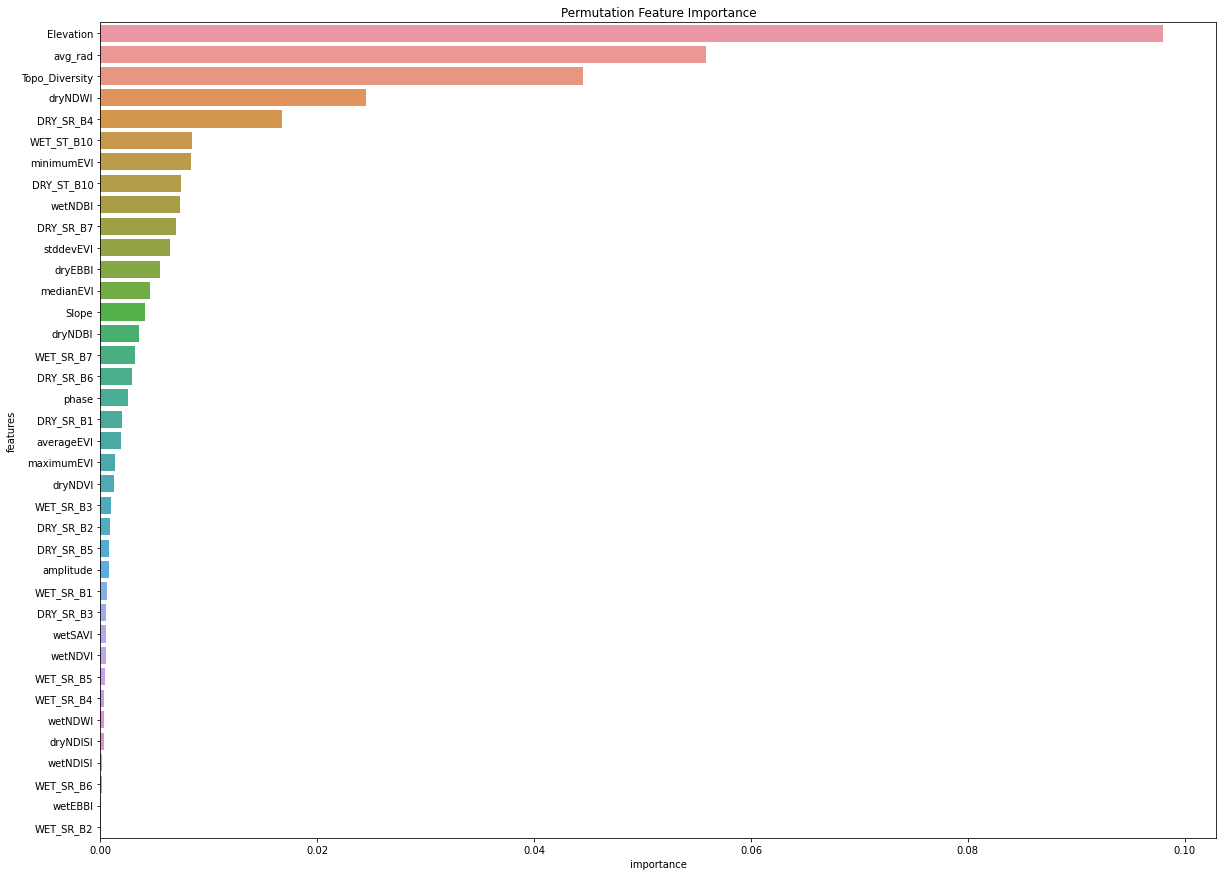

In [9]:
"""
Permutation Feature Importance : used to compute feature importances for any black-box model measuring how performance metrics decreases 
when a feature is not available.The basic idea of permutation importance is to permute (shuffle) the values of each feature and measure how much the permutation negatively 
impacts the performance of the metric. 
"""
# Perform permutation feature importance and store details in the dataframe for further analysis
perm = PermutationImportance(tuned_model, scoring='accuracy', random_state=10).fit(x_train.values, y_train)
perm_imp_df = pd.DataFrame()
perm_imp_df['features'] = x_trained_scaled.columns.tolist()
perm_imp_df['importance'] = perm.feature_importances_

perm_feature_importance_df = perm_imp_df.sort_values('importance', ascending=False).reset_index()

plt.rcParams['figure.figsize'] = 20,15
sns.barplot(x='importance', y='features', data=perm_feature_importance_df[:len(x_trained_scaled.columns.tolist())-1])
plt.title('Permutation Feature Importance')
plt.show

In [11]:
weights = eli5.show_weights(perm, feature_names = x_train.columns.tolist(), top=None)
display(weights)

In [10]:
# Fit model using each importance as a threshold
thresholds = sort(perm.feature_importances_)
for thresh in thresholds:

    perm_model = PermutationImportance(tuned_model, scoring='accuracy', random_state=10).fit(x_train.values, y_train)

    # select features using threshold
    selection = SelectFromModel(perm_model, threshold=thresh, prefit=True)
    selected_x_trained_scaled = selection.transform(x_train)
    
    # train model
    selection_model = lgbm.LGBMClassifier()
    selection_model.fit(selected_x_trained_scaled, y_train)
    
    # eval model
    selected_x_test = selection.transform(x_test)
    y_pred = selection_model.predict(selected_x_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.5f, n=%d, Accuracy: %.3f%%" % (thresh, selected_x_trained_scaled.shape[1], accuracy*100.0))

Thresh=0.00003, n=39, Accuracy: 99.301%


KeyboardInterrupt: ignored

In [11]:
# Fit model using each importance as a threshold
thresholds = sort(tuned_model.feature_importances_)
for thresh in thresholds:

    # select features using threshold
    selection = SelectFromModel(tuned_model, threshold=thresh, prefit=True)
    selected_x_trained_scaled = selection.transform(x_train)
    
    # train model
    selection_model = lgbm.LGBMClassifier()
    selection_model.fit(selected_x_trained_scaled, y_train)
    
    # eval model
    selected_x_test = selection.transform(x_test)
    y_pred = selection_model.predict(selected_x_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, selected_x_trained_scaled.shape[1], accuracy*100.0))

Thresh=50.000, n=39, Accuracy: 99.30%
Thresh=53.000, n=38, Accuracy: 99.31%
Thresh=55.000, n=37, Accuracy: 99.32%
Thresh=70.000, n=36, Accuracy: 99.30%
Thresh=79.000, n=35, Accuracy: 99.31%
Thresh=83.000, n=34, Accuracy: 99.29%
Thresh=92.000, n=33, Accuracy: 99.28%
Thresh=100.000, n=32, Accuracy: 99.26%
Thresh=110.000, n=31, Accuracy: 99.20%
Thresh=111.000, n=30, Accuracy: 99.33%
Thresh=129.000, n=29, Accuracy: 99.37%
Thresh=140.000, n=28, Accuracy: 99.36%
Thresh=147.000, n=27, Accuracy: 54.82%
Thresh=150.000, n=26, Accuracy: 99.37%
Thresh=154.000, n=25, Accuracy: 20.48%
Thresh=156.000, n=24, Accuracy: 61.72%
Thresh=175.000, n=23, Accuracy: 66.47%
Thresh=180.000, n=22, Accuracy: 99.41%
Thresh=189.000, n=21, Accuracy: 75.00%
Thresh=193.000, n=20, Accuracy: 71.75%
Thresh=204.000, n=19, Accuracy: 99.37%
Thresh=209.000, n=18, Accuracy: 99.37%
Thresh=218.000, n=17, Accuracy: 60.76%
Thresh=221.000, n=16, Accuracy: 99.33%
Thresh=231.000, n=15, Accuracy: 69.01%
Thresh=254.000, n=14, Accuracy: 

In [40]:
# perm.feature_importances_ attribute is now available, it can be used
# for feature selection - let's e.g. select features which increase
# accuracy by at least 0.05:
selection = SelectFromModel(tuned_model, threshold=204, prefit=True)
x_trained_scaled2 = selection.transform(x_train)
n_features = x_trained_scaled2.shape[1]
selected_feature = x_trained_scaled.columns[(selection.get_support())].tolist()
selected_feature

['DRY_SR_B1',
 'DRY_SR_B3',
 'DRY_SR_B4',
 'DRY_SR_B6',
 'DRY_SR_B7',
 'DRY_ST_B10',
 'WET_SR_B7',
 'WET_ST_B10',
 'medianEVI',
 'averageEVI',
 'maximumEVI',
 'minimumEVI',
 'stddevEVI',
 'phase',
 'amplitude',
 'Elevation',
 'Slope',
 'Topo_Diversity',
 'avg_rad']

<function matplotlib.pyplot.show>

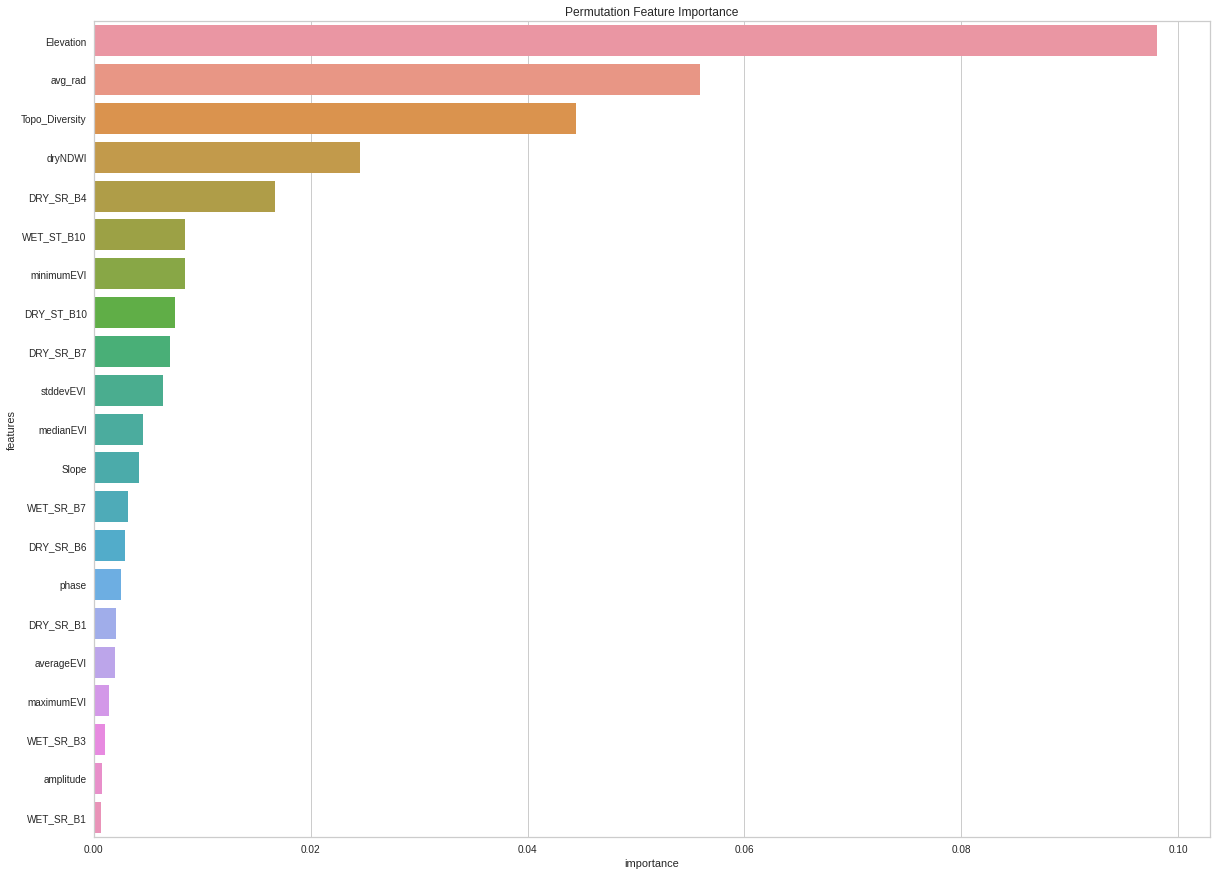

In [16]:
selection = SelectFromModel(tuned_model, threshold=180, prefit=True)
x_trained_scaled2 = selection.transform(x_trained_scaled)
n_features = x_trained_scaled2.shape[1]
selected_feature = x_trained_scaled.columns[(selection.get_support())]

perm_imp_df = pd.DataFrame()
perm_imp_df['features'] = x_trained_scaled.columns.tolist()
perm_imp_df['importance'] = perm.feature_importances_

perm_feature_importance_df = perm_imp_df.sort_values('importance', ascending=False).reset_index()
selected_perm = perm_feature_importance_df[perm_feature_importance_df['features'].isin(selected_feature.tolist())]

plt.rcParams['figure.figsize'] = 20,15
sns.barplot(x='importance', y='features', data=selected_perm[:len(selected_feature.tolist())-1])
plt.title('Permutation Feature Importance')
plt.show

In [17]:
# Summary Plot 
shap.initjs()
id = 0
explainer = shap.TreeExplainer(tuned_model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
  expected_value = expected_value[1][id]
print (expected_value[id])

features = test[test['id'] == id]
features_display = x_test.loc[features.index]
features_display_mean = pd.DataFrame(features_display.mean()).T

with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  shap_values = explainer.shap_values(features_display)
  shap_interaction_values = explainer.shap_interaction_values(features_display)
if isinstance(shap_interaction_values, list):
  shap_interaction_values = shap_interaction_values[id]
  
shap.summary_plot(shap_values[id], features_display, plot_type="violin")
#shap.decision_plot(expected_value[id], shap_values[id], features_display_mean, ignore_warnings= True)

TypeError: ignored

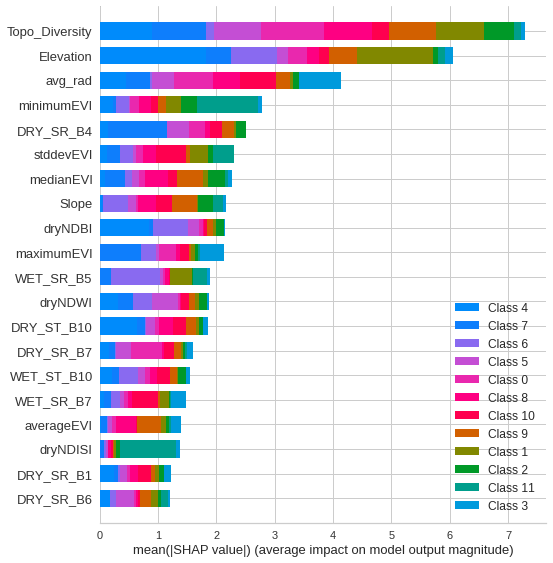

In [18]:
# Force Plot
interpret_model(tuned_model, plot = "summary")

##### ***Finalize and Predict Model***

In [81]:
# Predict Unseen data
predictions = predict_model(tuned_model, data=x_test)

In [82]:
holdout_score = pull()
type(holdout_score)
display(holdout_score)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9834  0.9994  0.9186  0.9832  0.9833  0.9800  0.9800
1       0.9823  0.9990  0.9350  0.9824  0.9823  0.9785  0.9785
2       0.9853  0.9993  0.9540  0.9854  0.9852  0.9822  0.9822
3       0.9857  0.9995  0.9313  0.9855  0.9856  0.9827  0.9827
4       0.9841  0.9996  0.9374  0.9840  0.9839  0.9808  0.9808
Mean    0.9842  0.9993  0.9353  0.9841  0.9840  0.9808  0.9808
SD      0.0012  0.0002  0.0114  0.0012  0.0012  0.0015  0.0015

In [83]:
# Print Accuracy, F1, and Kappa Coefficient
print('Classification Accuracy {:.2f}%'.format(100 * check_metric(yTest, predictions.Label, 'Accuracy')))
print('Classification F1-score {:.2f}%'.format(100 * check_metric(yTest, predictions.Label, 'F1')))
print('Classification Kappa {:.3f}'.format(check_metric(yTest, predictions.Label, 'Kappa')))

Classification Accuracy 98.46%
Classification F1-score 98.45%
Classification Kappa 0.982


In [23]:
selected_feature = ['DRY_SR_B1',
 'DRY_SR_B6',
 'DRY_SR_B7',
 'DRY_ST_B10',
 'WET_ST_B10',
 'dryNDWI',
 'medianEVI',
 'averageEVI',
 'minimumEVI',
 'stddevEVI',
 'phase',
 'amplitude',
 'Elevation',
 'Slope',
 'Topo_Diversity',
 'avg_rad']

In [24]:
#selected_features = ['avg_rad', 'Topo_Diversity', 'Elevation', 'phase', 'minimumEVI', 'amplitude', 'stddevEVI', 'Slope', 'medianEVI', 'averageEVI']

task = ee.batch.Export.image.toDrive(**{'image':composite.select(selected_feature).toFloat(),\
                                        'description':'composite',\
                                        'scale':30,\
                                        'region':watershed,\
                                        'folder':'Colab Notebooks'});

task.start()

i = 1
for features in selected_feature:
  print("No. of Variable: ", i)
  print("Variable Name: ", features)
  print("-------------------------------------------------------------------------------------------------------------------")
  i += 1

print ('Done ...')

No. of Variable:  1
Variable Name:  DRY_SR_B1
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  2
Variable Name:  DRY_SR_B6
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  3
Variable Name:  DRY_SR_B7
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  4
Variable Name:  DRY_ST_B10
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  5
Variable Name:  WET_ST_B10
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  6
Variable Name:  dryNDWI
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  7
Variable

In [ ]:
task = ee.batch.Export.image.toDrive(**{'image':dryContrast.toFloat(),\
                                        'description':'contrast',\
                                        'scale':30,\
                                        'region':watershed,\
                                        'folder':'Colab Notebooks'});
task.start()

## **Model Prediction**

In [25]:
from osgeo.gdalconst import *
from osgeo import gdal
from gdalconst import *

import os 
import enum
import matplotlib as mpl

try:
    import rasterio
except ImportError:
    print('Installing rasterio ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'rasterio'])

try:
    import geopandas
except ImportError:
    print('Installing rasterio ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geopandas'])

import rasterio
import geopandas as gpd 

Installing rasterio ...
Installing rasterio ...


In [26]:
#Load Composite
raster_path = '/content/drive/MyDrive/Colab Notebooks/composite.tif'

raster = gdal.Open(raster_path, gdal.GA_ReadOnly)

gtr = raster.GetGeoTransform()
dvr = raster.GetDriver()
col = raster.RasterXSize
row = raster.RasterYSize
bnd = raster.RasterCount
prj = raster.GetProjection()
    
array = []
    
for b in range(bnd+1)[1::]:
  band = raster.GetRasterBand(b)
  arry = band.ReadAsArray().astype(np.float32)
  array.append(arry)
  del band, arry

array = np.dstack(b for b in array)

# Array shape
w, h, b = array.shape

array = array.reshape(w*h,b)
array.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(38629584, 16)

In [33]:
# Split training dataset to train and test
train, test = train_test_split(data, test_size=0.3)

x_train, y_train = train[selected_feature], train['id'] # Optical + Topo
x_test, y_test = test[selected_feature], test['id']

# Convert array to dataframe
yTrain = pd.DataFrame(y_train)
yTest  = pd.DataFrame(y_test)

dfTrain = pd.concat([x_train, yTrain], axis=1)
dfTrain

DRY_SR_B1  DRY_SR_B6  DRY_SR_B7    DRY_ST_B10    WET_ST_B10   dryNDWI  \
52785   0.236117   0.431407   0.330037  38959.888889  29803.866667  0.091330   
33978   0.220382   0.331053   0.256830  38793.148148  28885.176471  0.241283   
5042    0.211786   0.239800   0.222623  40479.185185  27876.266667  0.046302   
20263   0.215277   0.314256   0.246771  37852.962963  34345.933333  0.202635   
58031   0.219050   0.340245   0.262667  38819.925926  26994.866667  0.243167   
...          ...        ...        ...           ...           ...       ...   
21078   0.207694   0.316113   0.259655  38989.888889  32397.176471  0.202505   
72220   0.292058   0.402853   0.398981  39014.407407  32159.200000 -0.071975   
36890   0.209654   0.310021   0.250863  39534.777778  35943.333333  0.229920   
32802   0.206766   0.309526   0.241622  37647.703704  34567.000000  0.226398   
57987   0.221407   0.333347   0.255147  40899.642857  28182.933333  0.252856   

       medianEVI  averageEVI  minimumEVI  stddevEVI     phase  amplitude  \
52785   0.463340    0.488143    0.073970   0.178579  0.019325   0.415718   
33978   0.572943    0.549644    0.183312   0.228320  0.608573   0.115840   
5042    0.130913    0.132506    0.032735   0.050338  0.010645   0.153129   
20263   0.413382    0.460093    0.195297   0.195193  0.942892   0.202594   
58031   0.755421    0.691043    0.202413   0.200877  0.103000   0.557292   
...          ...         ...         ...        ...       ...        ...   
21078   0.328567    0.349881    0.151648   0.134031  0.075446   0.112744   
72220   0.098784    0.114130   -0.007597   0.080562  0.219977   0.066284   
36890   0.475408    0.502153    0.177219   0.174650  0.607056   0.070570   
32802   0.391761    0.432357    0.153591   0.154010  0.313049   0.193356   
57987   0.703530    0.629649    0.243973   0.190874  0.999077   0.275129   

       Elevation      Slope  Topo_Diversity  avg_rad  id  
52785        101  20.697432        0.657136    1.195   9  
33978        715  29.043514        0.706746    0.185   4  
5042           6   1.065724        0.016809    0.345   1  
20263        713  17.395039        0.784648    0.240   4  
58031         98   3.185324        0.305411    0.665   8  
...          ...        ...             ...      ...  ..  
21078       1504  40.487106        0.935608    0.150   4  
72220         36   1.972039        0.069939   21.290   3  
36890        890  23.152216        0.868867    0.275   4  
32802       1051  13.577397        0.829004    0.210   4  
57987         16   3.242751        0.210927    1.090   8  

[54376 rows x 17 columns]

In [34]:
# Setup Environment
exp = setup(data = dfTrain, target = "id", feature_selection = True,\
             fold=5, fold_strategy="stratifiedkfold", preprocess = False, use_gpu=True)

Description             Value
0              session_id              8065
1                  Target                id
2             Target Type        Multiclass
3           Label Encoded              None
4           Original Data       (54376, 17)
5          Missing Values             False
6        Numeric Features                16
7    Categorical Features                 0
8   Transformed Train Set       (38063, 16)
9    Transformed Test Set       (16313, 16)
10     Shuffle Train-Test              True
11    Stratify Train-Test             False
12         Fold Generator   StratifiedKFold
13            Fold Number                 5
14               CPU Jobs                -1
15                Use GPU              True
16         Log Experiment             False
17        Experiment Name  clf-default-name
18                    USI              2468
19          Fix Imbalance             False
20   Fix Imbalance Method             SMOTE

In [35]:
# Create and Tune Model
model = create_model('lightgbm')
tuned_model = tune_model(model, optimize='F1')
print (tuned_model)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9896  0.9999  0.9549  0.9896  0.9896  0.9875  0.9875
1       0.9879  0.9999  0.9456  0.9879  0.9878  0.9854  0.9854
2       0.9886  0.9999  0.9479  0.9885  0.9885  0.9862  0.9862
3       0.9900  0.9999  0.9556  0.9900  0.9900  0.9879  0.9879
4       0.9887  0.9999  0.9396  0.9886  0.9886  0.9863  0.9864
Mean    0.9890  0.9999  0.9487  0.9889  0.9889  0.9867  0.9867
SD      0.0008  0.0000  0.0060  0.0008  0.0008  0.0009  0.0009

LGBMClassifier(bagging_fraction=0.7, bagging_freq=0, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.6,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=61, min_child_weight=0.001, min_split_gain=0.4,
               n_estimators=270, n_jobs=-1, num_leaves=50, objective=None,
               random_state=8065, reg_alpha=0.15, reg_lambda=0.1, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [36]:
labels_unique = np.unique(y_train)
labels_unique

# Setup Model
model = lgbm.LGBMClassifier(random_state=42, objective='multiclass', 
                            num_class=len(labels_unique),
                            metric='multi_logloss')

clf_sw = lgbm.LGBMClassifier(**model.get_params())

# Optimal parameter
clf_sw.set_params(**tuned_model.get_params())

# Fit classifier
clf_sw.fit(x_train, y_train)

LGBMClassifier(bagging_fraction=0.7, bagging_freq=0, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.6,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               metric='multi_logloss', min_child_samples=61,
               min_child_weight=0.001, min_split_gain=0.4, n_estimators=270,
               n_jobs=-1, num_class=12, num_leaves=50, objective=None,
               random_state=8065, reg_alpha=0.15, reg_lambda=0.1, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [37]:
# Mask Invalid Pixels
feature = np.ma.masked_invalid(array)
mask = np.ma.getmask(feature)
feature_mask = np.ma.array(feature, mask=mask)
feature_mask.shape

# Predict Model
predict = clf_sw.predict(feature_mask)
predict

array([ 1,  1,  1, ..., 11, 11, 11])

In [38]:
dfPred = np.array(pd.DataFrame(predict))
tiff = dfPred.reshape(w,h)
tiff.shape

(8068, 4788)

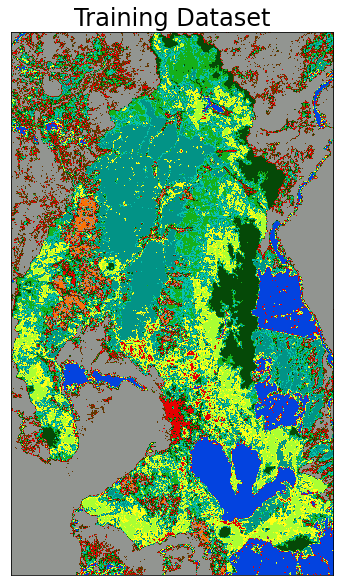

In [39]:
class LULC(enum.Enum):
    ANNUAL_CROP     = (0,  'Annual Crop',   'xkcd:orange')
    AQUACULTURE     = (1,  'Aquaculture',   'xkcd:grey')
    BARREN_LAND     = (2,  'Barren land',   'xkcd:brown')
    DENSE_URBAN     = (3,  'Dense Urban',   'xkcd:red')
    FOREST          = (4,  'Forest',        'xkcd:darkgreen')
    GRASSLAND       = (5,  'Grassland',     'xkcd:green')
    MANGROVE        = (6,  'Mangrove',      'xkcd:turquoise')
    PADDY_RICE      = (7,  'Paddy Rice',    'xkcd:Teal')
    PERMANENT_CROP  = (8,  'Permanent Crop','xkcd:yellow')
    SHRUBLAND       = (9,  'Shrubland',     'xkcd:lime')
    SPARSE_URBAN    = (10, 'Sparse Urban',  'xkcd:red')
    WATER           = (11, 'Water',         'xkcd:blue')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])

plt.figure(figsize=(20,10))
plt.imshow(tiff, cmap=lulc_cmap)
plt.xticks([])
plt.yticks([])
plt.title('Training Dataset', fontsize=24)
plt.show()

In [40]:
# Export Data 
driver = raster.GetDriver()
outputPath = '/content/drive/MyDrive/Colab Notebooks'

with rasterio.open(raster_path) as src:
  b1 = src.read(1)

kwargs = src.meta
kwargs.update(dtype=rasterio.float32, count=1)
with rasterio.open (outputPath+'/'+'manilaBayWatershed_Landcover_20152016'+'.tiff', 'w', **kwargs) as dst:
  dst.write_band(1, tiff.astype(rasterio.float32))

In [41]:
del tiff, predict, array, feature, feature_mask, mask